In [71]:
from __future__ import print_function    

import time
import math
import numpy as np
import pylab as py
import scipy.sparse as sp                 # import sparse matrix library
from scipy.sparse.linalg import spsolve


# Import all necessary libraries, this is a configuration step for the exercise.
# Please run it before the simulation code!
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt


import scipy.sparse as sp

def Diff_mat_1D(Nx):
    
    # First derivative
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx)) # A division by (2*dx) is required later.
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]               # this is 2nd order forward difference (2*dx division is required)
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  # this is 2nd order backward difference (2*dx division is required)
    
    # Second derivative
    D2_1d =  sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx)) # division by dx^2 required
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    # this is 2nd order forward difference. division by dx^2 required. 
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  # this is 2nd order backward difference. division by dx^2 required.
    
    return D_1d, D2_1d



    # Defining custom plotting functions
def my_contourf(x,y,F,ttl):
    cnt = py.contourf(x,y,F,41,cmap = 'inferno')
    py.colorbar()
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0
    

def my_scatter(x,y,clr,ttl):
    py.plot(x,y,'.',markersize=2,color=clr)
    py.xlabel('x'); py.ylabel('y'); py.title(ttl)
    return 0


def Diff_mat_2D(Nx,Ny):
    # 1D differentiation matrices
    Dx_1d, D2x_1d = Diff_mat_1D(Nx)
    Dy_1d, D2y_1d = Diff_mat_1D(Ny)
    
      # Sparse identity matrices
    Ix = sp.eye(Nx)
    Iy = sp.eye(Ny)


    
    # 2D matrix operators from 1D operators using kronecker product
    # First partial derivatives
    Dx_2d = sp.kron(Iy,Dx_1d)
    Dy_2d = sp.kron(Dy_1d,Ix)
    
    # Second partial derivatives
    D2x_2d = sp.kron(Iy,D2x_1d)
    D2y_2d = sp.kron(D2y_1d,Ix)
    
    
    return Dx_2d.tocsr(), Dy_2d.tocsr(), D2x_2d.tocsr(), D2y_2d.tocsr()




def poisson_solve2D(sXInew): 




    #==============================================================================
    # Dirichlet/Neumann boundary conditions at outerwalls (boundary condition type is defined through boundary operators)


    # define the boundary conditions for the stream function

    uL = 0
    uR = 0
    uT = 0
    uB = 0
    #==============================================================================


    #==============================================================================
    # Define independent variables
    Nx = 100                         # No. of grid points along x direction
    Nz = Nx                         # No. of grid points along y direction
    x = np.linspace(-6,6,Nx)        # x variables in 1D
    z = np.linspace(-3,3,Nz)        # y variable in 1D
    #==============================================================================

    #//////////////////////////////////////////////////////////////////////////////
    #//////////////////////////////////////////////////////////////////////////////
    #//////////////////////////////////////////////////////////////////////////////

    #==============================================================================


    dx = x[1] - x[0]                # grid spacing along x direction
    dz = z[1] - z[0]                # grid spacing along y direction

    X,Z = np.meshgrid(x,z)          # 2D meshgrid

    # 1D indexing
    Xu = X.ravel()                  # Unravel 2D meshgrid to 1D array
    Zu = Z.ravel()


    # Source function (right hand side vector)
    g = -sXInew 


    # Loading finite difference matrix operators
    Dx_2d, Dz_2d, D2x_2d, D2z_2d = Diff_mat_2D(Nx,Nz)   # Calling 2D matrix operators from funciton



    #//////////////////////////////////////////////////////////////////////////////
    #//////////////////////////////////////////////////////////////////////////////
    #//////////////////////////////////////////////////////////////////////////////


    #==============================================================================
    # Boundary indices
    start_time = time.time()
    ind_unravel_L = np.squeeze(np.where(Xu==x[0]))          # Left boundary
    ind_unravel_R = np.squeeze(np.where(Xu==x[Nx-1]))       # Right boundary
    ind_unravel_B = np.squeeze(np.where(Zu==z[0]))          # Bottom boundary
    ind_unravel_T = np.squeeze(np.where(Zu==z[Nz-1]))       # Top boundary

    ind_boundary_unravel = np.squeeze(np.where((Xu==x[0]) | (Xu==x[Nx-1]) | (Zu==z[0]) | (Zu==z[Nz-1])))  # outer boundaries 1D unravel indices
    ind_boundary = np.where((X==x[0]) | (X==x[Nx-1]) | (Z==z[0]) | (Z==z[Nz-1]))    # outer boundary



    #print("Boundary search time = %1.6s" % (time.time()-start_time))

    # Plot solution domain (with boundary)

    #py.close('all')
    #my_scatter(X,Z,'g','Solution grid')
    #my_scatter(X[ind_boundary], Z[ind_boundary],'r','Solution grid with boundary')
    #my_scatter(X[ind_boundary2], Z[ind_boundary2],'b','')
    #==============================================================================

    #//////////////////////////////////////////////////////////////////////////////
    #//////////////////////////////////////////////////////////////////////////////
    #//////////////////////////////////////////////////////////////////////////////


    #==============================================================================
    # Construction of the system matrix
    start_time = time.time()
    I_sp = sp.eye(Nx*Nz).tocsr()
    L_sys = D2x_2d/dx**2 + D2z_2d/dz**2     # system matrix without boundary conditions

    # Boundary operators
    BD = I_sp       # Dirichlet boundary operator
    BNx = Dx_2d     # Neumann boundary operator for x component
    BNy = Dz_2d     # Neumann boundary operator for y component

    
    L_sys[ind_unravel_T,:] = BNy[ind_unravel_T,:]    # Boundaries at the top layer
    L_sys[ind_unravel_B,:] = BD[ind_unravel_B,:]    # Boundaries at the bottom layer
    L_sys[ind_unravel_L,:] = BNx[ind_unravel_L,:]    # Boundaries at the left layer
    L_sys[ind_unravel_R,:] = BNx[ind_unravel_R,:]    # Boundaries at the right edges

    #==============================================================================

   
    # Construction of right hand vector (function of x and y)
    b = g
    # Insert boundary values at the boundary points
    #b[ind_unravel_L] = uL
    #b[ind_unravel_R] = uR
    #b[ind_unravel_T] = uT
    #b[ind_unravel_B] = uB

    #b[ind_boundary2_unravel] = ub2
    #==============================================================================

    # solve
    start_time = time.time()
    u = spsolve(L_sys,b).reshape(Nz,Nx)

    return(u)


<IPython.core.display.Javascript object>


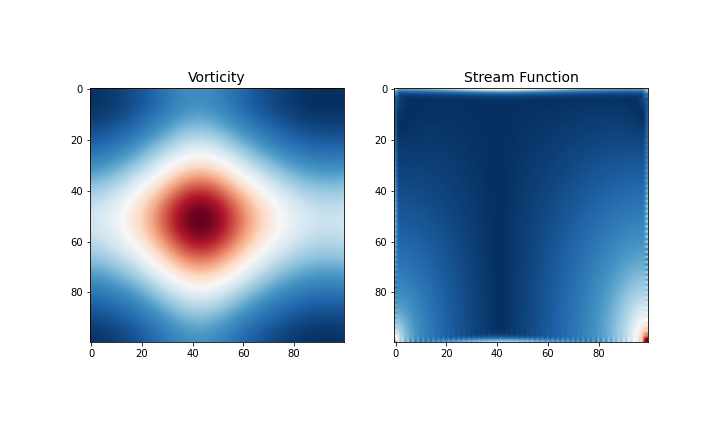

In [228]:
#encoding: utf-8
    # Initialize animated plot
# ---------------------------------------------------------------
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
line1 = ax1.imshow(sXI_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
line2 = ax2.imshow(psi_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
ax1.set_title('Vorticity', size=14)
ax2.set_title('Stream Function', size=14)

plt.ion()   # set interective mode
plt.show()

fig.savefig("C:/Users/patri/Dropbox/Ph.D/Fluid_Mechanics/Project/SF-Vort.pdf")


<IPython.core.display.Javascript object>


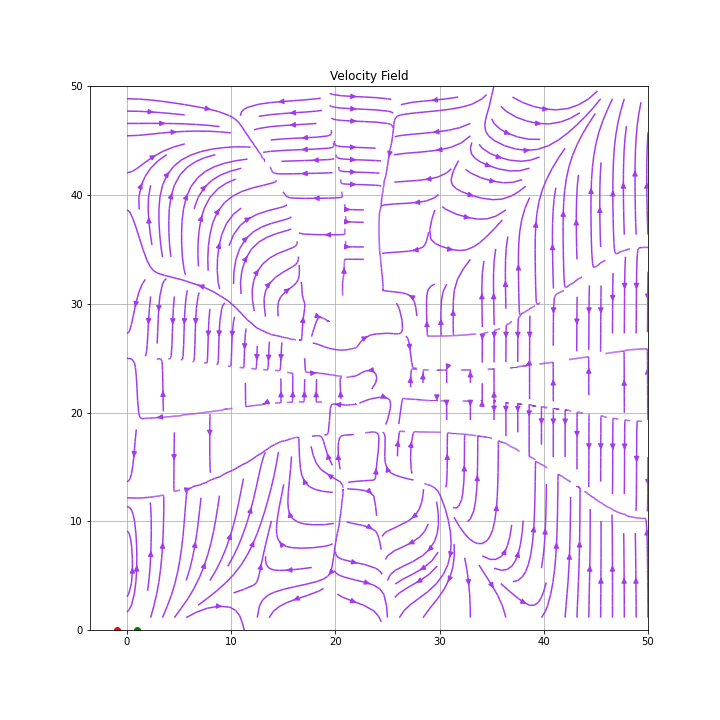

In [225]:
# Depict illustration
plt.figure(figsize=(10, 10))
plt.streamplot(X,Z,u,v, density=1.5, linewidth=None, color='#A23BEC')
plt.plot(-1,0,'-or')
plt.plot(1,0,'-og')
plt.title('Velocity Field')
 
# Show plot with grid
plt.grid()
plt.show()

#plt.contourf(psi_sec)

#plt.contourf(np.exp(-(((0.5*(X-100))-np.pi+(np.pi/5))**2+((0.5*(Z-100))-np.pi+(np.pi/5))**

In [230]:
def fourier_derivative_1st(f, dx):
        # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**1 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num



def fourier_derivative_2nd(f, dx):
    # Length of vector f
    nx = np.size(f)
    # Initialize k vector up to Nyquist wavenumber 
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))
    k[: int(nx/2)] = k[: int(nx/2)] * dk 
    k[int(nx/2) :] = k[: int(nx/2)] - kmax
    
    # Fourier derivative
    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num




    # Basic parameters
# ---------------------------------------------------------------
nt    = 100   # number of time steps
nx    = 100     # number of grid points in x 
nz    = nx      # number of grid points in z

isnap = 600     # snapshot frequency
xmax  = 50
iplot = 20
# initialization of vorticity field in time domain
#aXI = np.zeros((nx, nz), dtype=float)
#aXInew = np.zeros((nx, nz), dtype=float)
#aXIold = np.zeros((nx, nz), dtype=float)
#ad2XIx = np.zeros((nx, nz), dtype=float)
#ad2XIz = np.zeros((nx, nz), dtype=float) 
# aXI_sec = -np.abs(aXI[int(nx/2):nx, 1:int(nz/2)].T)


# initialization of vorticity field in fourier domain 

sXInew = np.zeros((nx, nz), dtype=float)
sXIold = np.zeros((nx, nz), dtype=float)
sdXIx = np.zeros((nx, nz), dtype=float)
sdXIz = np.zeros((nx, nz), dtype=float); 
sd2XIx = np.zeros((nx, nz), dtype=float)
sd2XIz = np.zeros((nx, nz), dtype=float); 


# initialize the stream function

psi_new = np.zeros((nx, nz), dtype=float)
psi_old = np.zeros((nx, nz), dtype=float)
psi = np.zeros((nx, nz), dtype=float)



# initialization of velocity field
u_old = np.zeros((nx,nz), dtype = float)
v_old = np.zeros((nx,nz), dtype = float)
u = np.zeros((nx,nz), dtype = float)
v = np.zeros((nx,nz), dtype = float)
u_new = np.zeros((nx,nz), dtype = float)
v_new = np.zeros((nx,nz), dtype = float)

dx = xmax/(nx-1)  # calculate space increment
x  = np.arange(0, nx)*dx # initialize space coordinates
z  = np.arange(0, nx)*dx # initialize space coordinates
dt = 0.01



# initialize the meshgrid

X,Z = np.meshgrid(x,z)


sXI = np.exp(-(((1.0*(X-20))-np.pi+(np.pi/5))**2+((0.5*(Z-20))-np.pi+(np.pi/5))**2)/7)-\
np.exp(-(((1.0*(X-20))-np.pi-(np.pi/5))**2+((1.0*(Z-20))-np.pi+(np.pi/5))**2)/6)+\
np.exp(-((1.0*(1.0*(X-20))-np.pi-(np.pi/5))**2+((1.0*(Z-20))-np.pi-(np.pi/4))**2)/6)

#h = plt.contourf(x,z,sXI)

# rho: liquid density
# mu: liquid kinematic viscosity
# XI: vorticity
# sdXIx: first fourier derivative of XI w.r.t x
# sdXIz: first fourier derivative of XI w.r.t z
# sd2XIx: second fourier derivative of XI w.r.t x
# sd2XIz: second fourier derivative of XI w.r.t z
# sXInew: new time iteration value for XI


# Time extrapolation
# ---------------------------------------------------------------



#--------------------------------- MAIN PROGRAM---------------------------------------------#
mu = 0.005
rho = 1.0
for it in range(nt):
    
    print("it",it)
   
    # ----------------------------------------
    # Fourier Pseudospectral Method
    # ----------------------------------------
    
        # 1st space derivative
    for j in np.arange(nz):           
        sdXIx[:,j] = fourier_derivative_1st(sXI[:,j].T, dx) 
    for i in np.arange(nx):           
        sdXIz[i,:] = fourier_derivative_1st(sXI[i,:], dx)
    
    # 2nd space derivative
    for j in np.arange(nz):           
        sd2XIx[:,j] = fourier_derivative_2nd(sXI[:,j].T, dx) 
    for i in np.arange(nx):           
        sd2XIz[i,:] = fourier_derivative_2nd(sXI[i,:], dx)
        
    # Time Extrapolation
    # need to properly define these first derivatives
    
    sXInew = dt*(mu/rho)*(sd2XIx + sd2XIz)-(u*sdXIx)-(v*sdXIz)
    


    # ----------------------------------------
    # Finite Differences Method 5pt
    # ----------------------------------------
    #for i in range(2, nz-2):
    #    ad2XIx[i,:] = (-1./12*aXI[i+2,:] + 4./3*aXI[i+1,:] - 5./2*aXI[i,:] \
    #                  + 4./3*aXI[i-1,:] - 1./12*aXI[i-2,:])/dx**2 # Space derivative 
    #for i in range(2, nx-2):
    #    ad2XIz[:,i] = (-1./12*aXI[:,i+2] + 4./3*aXI[:,i+1] - 5./2*aXI[:,i] \
    #                  + 4./3*aXI[:,i-1] - 1./12*aXI[:,i-2])/dx**2 # Space derivative 
        
    #sXInew = dt*(mu/rho)*(sd2XIx + sd2XIz)-(u*sdXIx)-(v*sdXIz)
    
    
    
  
    
    # solve for the stream function using poisson solver
    psi_new = poisson_solve2D(sXInew.ravel())

    # use the 5-pt difference method to obtain the spatial derivatives of the velocity field
    # which is the first spatial derivative of the stream function
    
    for i in range (2,nx-2):
        u_new[i,:] = (-1./12*psi_new[i+2,:] + 4./3*psi_new[i+1,:] - 5./2*psi_new[i,:] \
                      + 4./3*psi_new[i-1,:] - 1./12*psi_new[i-2,:])/dx**2
    
    for i in range(2, nz-2):
        v_new[i,:] = -(-1./12*psi_new[:,i+2] + 4./3*psi_new[:,i+1] - 5./2*psi_new[:,i] \
                      + 4./3*psi_new[:,i-1] - 1./12*psi_new[:,i-2])/dx**2
    
    
    # velocity time levels
    u_old, u = u, u_new # Time levels
    v_old, v = v, v_new
    
    
    vel_mag = ((u**2)+(v**2))**(1/2)

    
    #vorticity field time levels
    sXIold, sXI = sXI, sXInew # Time levels
    
    #stream function time levels
    psi_old, psi = psi, psi_new
 
    
    # Select Sections for plotting
    sXI_sec = -np.abs(sXI[0:int(nx), 0:int(nz)])
    
    u_sec = -np.abs(u[0:int(nx), :int(nz)])
    
    psi_sec = -np.abs(psi[0:int(nx), 0:int(nz)])
    
    #print("psi_sec",psi_sec)
    #aXI_sec = -np.abs(aXI[int(nx/2):nx, 1:int(nz/2)].T)
    
    # --------------------------------------  
    # Animation plot. Display solution  
    # --------------------------------------
    if not it % iplot:                    
        # Display Solution
        # -------------------------------------- 
        line1 = ax1.imshow(sXI_sec, interpolation="bicubic", cmap=plt.cm.RdBu) 
        line2 = ax2.imshow(psi_sec, interpolation="bicubic", cmap=plt.cm.RdBu)
        plt.gcf().canvas.draw()




it 0
it 1
it 2
it 3
it 4
it 5
it 6
it 7
it 8
it 9
it 10
it 11
it 12
it 13
it 14
it 15
it 16
it 17
it 18
it 19
it 20
it 21
it 22
it 23
it 24
it 25
it 26
it 27
it 28
it 29
it 30
it 31
it 32
it 33
it 34
it 35
it 36
it 37
it 38
it 39
it 40
it 41
it 42
it 43
it 44
it 45
it 46
it 47
it 48
it 49
it 50
it 51
it 52
it 53
it 54
it 55
it 56
it 57
it 58
it 59
it 60
it 61
it 62
it 63
it 64
it 65
it 66
it 67
it 68
it 69
it 70
it 71
it 72
it 73
it 74
it 75
it 76
it 77
it 78
it 79
it 80
it 81
it 82
it 83
it 84
it 85
it 86
it 87
it 88
it 89
it 90
it 91
it 92
it 93
it 94
it 95
it 96
it 97
it 98
it 99


In [137]:
plot(psi_sec)

NameError: name 'plot' is not defined

<IPython.core.display.Javascript object>


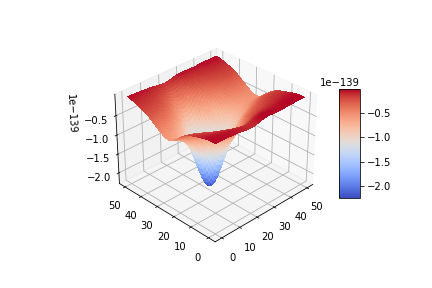

In [190]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
#surf = ax.plot_surface(X,Z, sd2XIx, cmap=plt.cm.coolwarm,
#                       linewidth=0, antialiased=False)

surf = ax.plot_surface(X,Z, sXI_sec, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [84]:
psi_sec.shape

#sd2XIz.shape

(50, 50)

In [64]:
Z.shape

(50, 50)

<IPython.core.display.Javascript object>


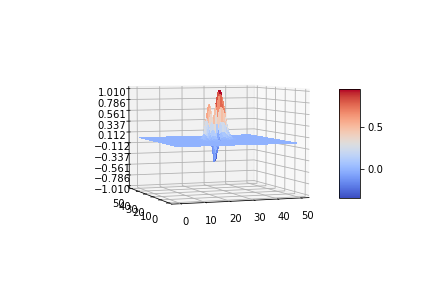

In [191]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0, 50, 0.25)
Y = np.arange(0, 50, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.exp(-(((1.0*(X-20))-np.pi+(np.pi/5))**2+((0.5*(Y-20))-np.pi+(np.pi/5))**2)/3)-\
np.exp(-((((X-20))-np.pi-(np.pi/5))**2+((0.5*(Y-20))-np.pi+(np.pi/5))**2)/2)+\
np.exp(-((1.0*(0.5*(X-20))-np.pi-(np.pi/5))**2+((0.5*(Y-20))-np.pi-(np.pi/4))**2)/2)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


In [79]:
Z.shape

(40, 28)